# 00_preprocessing — Preprocesado común (recorte, filtros, estructura de datos)

### Objetivo: centralizar el preprocesado de los datos en un único notebook, para evitar repetir código en los notebooks de análisis.

## 1) Imports y configuración

In [34]:
import os, sys
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))

# Para usar las funciones comunes
from src.utils import recortar_imagen, procesar_imagen, new_images

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## 2) Paths y parámetros

In [35]:
# Entradas/salidas
INPUT_FOLDER = '../imagenes_huellas' # carpeta original 
CROPPED_FOLDER = '../imagenes_recortadas' # salida del recorte
FILTERED_FOLDER = '../imagenes_filtradas' # salida del filtrado

# Carpetas derivadas 
USER_DB_DIR = '../user_database' # para SIFT
USER_PRUEBA_DIR = '../user_prueba' # para augment de SIFT

# Estructura para el notebook CNN 
DATA_DIR = '../data'
TRAIN_AUTH = os.path.join(DATA_DIR, 'train', 'authenticated')
TRAIN_REJ = os.path.join(DATA_DIR, 'train', 'rejected')
TEST_AUTH = os.path.join(DATA_DIR, 'test', 'authenticated')
TEST_REJ = os.path.join(DATA_DIR, 'test', 'rejected')

# Parámetros de recorte
CROP_WIDTH = 550
CROP_HEIGHT = 550
THRESHOLD_VALUE = 225

# Parámetros de filtrado 
CLAHE_CLIP = 1.0
CLAHE_GRID = (8, 8)
BILATERAL_D = 9
BILATERAL_SIGMA_COLOR = 75
BILATERAL_SIGMA_SPACE = 75
MEDIAN_KSIZE = 3
ADAPT_BLOCK = 19
ADAPT_C = 3
MORPH_KERNEL = 3
USE_SKELETON = False 
FINAL_SIZE = (550, 550)

# Augment
AUG_PER_IMAGE_SIFT = 10 # cuántas variantes por imagen para `user_prueba`
AUG_CNN_PER_IMAGE = 100 # cuántas variantes por imagen en cada carpeta de train/test 

## 3) Recorte (→ imagenes_recortadas)

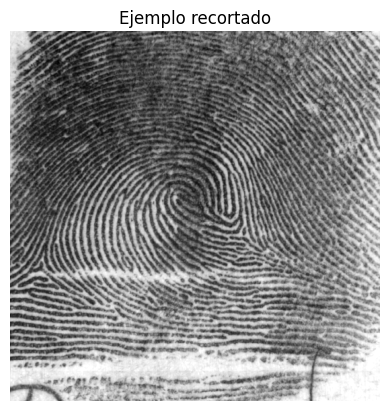

In [36]:
os.makedirs(CROPPED_FOLDER, exist_ok=True)
recortar_imagen(
    input_folder=INPUT_FOLDER,
    output_folder=CROPPED_FOLDER,
    crop_width=CROP_WIDTH,
    crop_height=CROP_HEIGHT,
    threshold_value=THRESHOLD_VALUE,
)

# Vista rápida de una muestra si existe
sample_path = None
for f in os.listdir(CROPPED_FOLDER):
    if f.lower().endswith('.png'):
        sample_path = os.path.join(CROPPED_FOLDER, f)
        break

if sample_path:
    import cv2
    img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray'); plt.title('Ejemplo recortado'); plt.axis('off'); plt.show()

## 4) Filtrado (→ imagenes_filtradas)

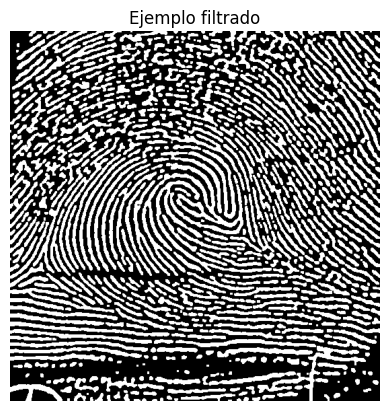

In [37]:
os.makedirs(FILTERED_FOLDER, exist_ok=True)

for root, _, files in os.walk(CROPPED_FOLDER):
    for file in files:
        if not file.lower().endswith('.png'):
            continue
        in_path = os.path.join(root, file)
        out_path = os.path.join(FILTERED_FOLDER, file)
        procesar_imagen(
            image_path=in_path,
            output_path=out_path,
            clahe_clip=CLAHE_CLIP,
            clahe_grid=CLAHE_GRID,
            bilateral_d=BILATERAL_D,
            bilateral_sigma_color=BILATERAL_SIGMA_COLOR,
            bilateral_sigma_space=BILATERAL_SIGMA_SPACE,
            median_ksize=MEDIAN_KSIZE,
            adapt_block=ADAPT_BLOCK,
            adapt_C=ADAPT_C,
            morph_kernel=MORPH_KERNEL,
            use_skeleton=USE_SKELETON,
            final_size=FINAL_SIZE,
        )

# Vista rápida
sample_path = None
for f in os.listdir(FILTERED_FOLDER):
    if f.lower().endswith('.png'):
        sample_path = os.path.join(FILTERED_FOLDER, f)
        break

if sample_path:
    import cv2
    img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray'); plt.title('Ejemplo filtrado'); plt.axis('off'); plt.show()

## 5) Crear user_database (SIFT)

In [38]:
os.makedirs(USER_DB_DIR, exist_ok=True)

for image_name in os.listdir(FILTERED_FOLDER):
    if not image_name.lower().endswith('.png'):
        continue
    user_id = image_name[:2] 
    user_dir = os.path.join(USER_DB_DIR, f"user{user_id}")
    os.makedirs(user_dir, exist_ok=True)
    shutil.copy(os.path.join(FILTERED_FOLDER, image_name), os.path.join(user_dir, image_name))

print('Base de datos creada en', USER_DB_DIR)

Base de datos creada en ../user_database


## 6) user_prueba con data augmentation (SIFT)

In [39]:
os.makedirs(USER_PRUEBA_DIR, exist_ok=True)

# Limpia destino para evitar duplicados
for f in os.listdir(USER_PRUEBA_DIR):
    try:
        os.remove(os.path.join(USER_PRUEBA_DIR, f))
    except Exception:
        pass

# Copiamos base y luego augmentamos
for f in os.listdir(FILTERED_FOLDER):
    if f.lower().endswith('.png'):
        shutil.copy(os.path.join(FILTERED_FOLDER, f), os.path.join(USER_PRUEBA_DIR, f))

# Augment
new_images(USER_PRUEBA_DIR, num_images=AUG_PER_IMAGE_SIFT, cut_on_rejected=False)
print('Augment terminado en', USER_PRUEBA_DIR)

Augment terminado en ../user_prueba


## 7) Estructura para CNN (data/train|test/authenticated|rejected)

Contexto de autenticación (justificación del split f/s): en este sistema de autenticación se trabaja con un conjunto de usuarios registrados. El modelo aprende con sus huellas y, más tarde, verifica nuevas capturas de los mismos usuarios. Por eso, usar f como entrenamiento y s como verificación no supone fuga de información: es coherente con el escenario real de uso.

f → primeras capturas usadas para entrenar (y construir las clases o la base de referencia).

s → segundas capturas del mismo usuario para verificar.

Diferencia con identificación abierta: si quisieras medir la capacidad de generalizar a usuarios nunca vistos (identificación), entonces sí se tendría que separar por usuario (p. ej., 7 usuarios en train y 3 en test). No es el objetivo aquí.

In [40]:
# Crea carpetas
os.makedirs(TRAIN_AUTH, exist_ok=True)
os.makedirs(TRAIN_REJ, exist_ok=True)
os.makedirs(TEST_AUTH, exist_ok=True)
os.makedirs(TEST_REJ, exist_ok=True)

# Limpia en caso de re-ejecución
for d in [TRAIN_AUTH, TRAIN_REJ, TEST_AUTH, TEST_REJ]:
    for f in os.listdir(d):
        try:
            os.remove(os.path.join(d, f))
        except Exception:
            pass

# Selección de imágenes
all_filtered = [img for img in os.listdir(FILTERED_FOLDER) if img.lower().endswith('.png')]
train_images = [img for img in all_filtered if 'f' in img]
test_images = [img for img in all_filtered if 's' in img]

# Copia train
mid = len(train_images) // 2
for idx, image in enumerate(sorted(train_images)):
    src = os.path.join(FILTERED_FOLDER, image)
    dst_dir = TRAIN_AUTH if idx < mid else TRAIN_REJ
    shutil.copy(src, os.path.join(dst_dir, image))

# Copia test
mid = len(test_images) // 2
for idx, image in enumerate(sorted(test_images)):
    src = os.path.join(FILTERED_FOLDER, image)
    dst_dir = TEST_AUTH if idx < mid else TEST_REJ
    shutil.copy(src, os.path.join(dst_dir, image))

print('Estructura CNN creada en', DATA_DIR)

Estructura CNN creada en ../data


## 8) (Opcional) Data augmentation para CNN

In [41]:
DO_AUG_CNN = True  # opcional

if DO_AUG_CNN:
    for directory in [TRAIN_AUTH, TRAIN_REJ]:   # solo entrenamiento
        new_images(directory, num_images=AUG_CNN_PER_IMAGE, cut_on_rejected=True)
    print('Augment CNN aplicado SOLO en train')
else:
    print('Augment CNN desactivado (DO_AUG_CNN=False)')

Augment CNN aplicado SOLO en train


## 9) Resumen rápido de conteos

In [42]:
def count_pngs(path):
    return sum(1 for f in os.listdir(path) if f.lower().endswith('.png')) if os.path.isdir(path) else 0

print('Recortadas:', count_pngs(CROPPED_FOLDER))
print('Filtradas :', count_pngs(FILTERED_FOLDER))
print('user_db :', sum(count_pngs(os.path.join(USER_DB_DIR, d)) for d in os.listdir(USER_DB_DIR)))
print('user_prueba:', count_pngs(USER_PRUEBA_DIR))
print('train/auth:', count_pngs(TRAIN_AUTH))
print('train/rej :', count_pngs(TRAIN_REJ))
print('test/auth :', count_pngs(TEST_AUTH))
print('test/rej :', count_pngs(TEST_REJ))

Recortadas: 20
Filtradas : 20
user_db : 20
user_prueba: 220
train/auth: 505
train/rej : 505
test/auth : 5
test/rej : 5
